1.  Combine all blocks into a single dataframe- keeping on relevant columns.
2. Use day-level energy consumption data per household to normalize data for inconsistent household count
3. Add Weather Data with Energy Consumption Data
4. Add UK holidays data to the day level data as an indicator.
5. Find relationships between Energy Consumption and Weather as well as Holidays

# Daily Energy Data Preparation

**Importing Libraries **

In [5]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import os

### Energy Data

> We are predicting for energy demand in the future- therefore we are taking only energy sum i.e. total energy use per day for a given household.

In [3]:
# Combining all blocks
for num in range(0,112):
    df = pd.read_csv("D:/Project/smart-meters-in-london/daily_dataset/block_"+str(num)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("D:/Project/smart-meters-in-london/outputfiles/hc_"+str(num)+".csv",index=False)

fout= open("D:/Project/smart-meters-in-london/outputfiles/energy.csv","a")
# first file:
for line in open("D:/Project/smart-meters-in-london/outputfiles/hc_0.csv"):
    fout.write(line)
# now the rest:    
for num in range(0,112):
    f = open("D:/Project/smart-meters-in-london/outputfiles/hc_"+str(num)+".csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()

** Energy at Day Level **

In [17]:
energy = pd.read_csv('D:/Project/smart-meters-in-london/outputfiles/energy.csv')

In [18]:
len(energy)

3536007

In [19]:
energy.head(5)

day      LCLid  energy_sum
0  2012-10-12  MAC000002       7.098
1  2012-10-13  MAC000002      11.087
2  2012-10-14  MAC000002      13.223
3  2012-10-15  MAC000002      10.257
4  2012-10-16  MAC000002       9.769

In [20]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3536007 entries, 0 to 3536006
Data columns (total 3 columns):
day           object
LCLid         object
energy_sum    float64
dtypes: float64(1), object(2)
memory usage: 80.9+ MB


**House Count**
> In the dataset we see that the number of households for which energy data was collected across different days are different. This is probably due to the gradually increasing adoption of smart meters in London.  This could lead to false interpretation that the energy for a particular day might be high when it could be that the data was only collected for more number of houses. We will look at the house count for each day.  

In [21]:
housecount = energy.groupby('day')[['LCLid']].nunique()

In [22]:
housecount.rename(columns={"LCLid": "HouseCount"})
housecount.columns = ["HouseCount"]

In [23]:
housecount.head(7)

HouseCount
day                   
2011-11-23          13
2011-11-24          25
2011-11-25          32
2011-11-26          41
2011-11-27          41
2011-11-28          55
2011-11-29          63

In [16]:
len(housecount)

829

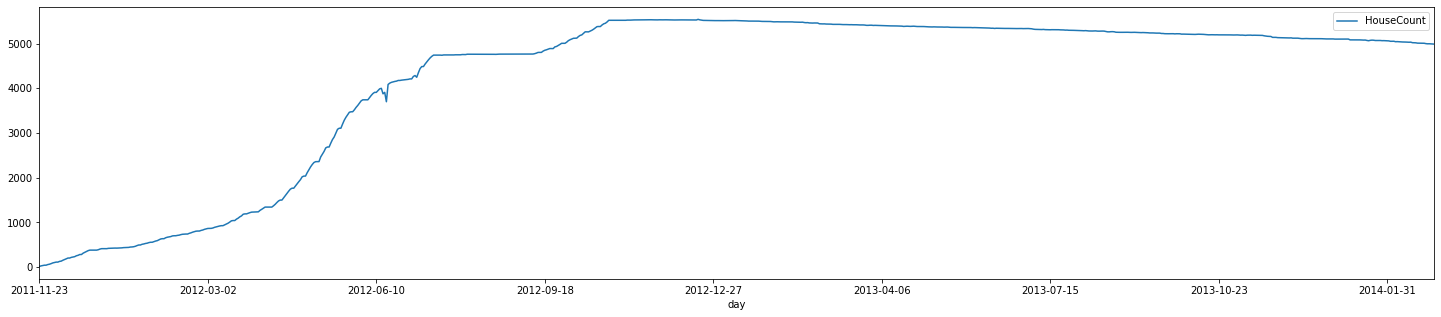

In [10]:
housecount.plot(figsize=(25,5))

In [1]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='MonthlyHouseCountTrend&#47;MonthlyHouseCountTrend' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

**Normalization across households**
> The data collection across households are inconsistent- therefore we will be using *energy per household* as the target to predict rather than energy alone. This is an optional step as we can also predict for energy sum as whole for each household. However there are quite a lot of unique households for which we have to repeat the exercise and our ultimate goal is to predict overall consumption forecast and not at household level.  
This also means that since household level is removed, we are not looking into the ACORN details which is available at household level

In [27]:
energy_per_house = energy.groupby('day')[['energy_sum']].sum()
energy_per_house = energy_per_house.merge(housecount, on = ['day'])
energy_per_house = energy_per_house.reset_index()

In [28]:
energy_per_house.head(5)

day  energy_sum  HouseCount
0  2011-11-23   90.385000          13
1  2011-11-24  213.412000          25
2  2011-11-25  303.993000          32
3  2011-11-26  420.976000          41
4  2011-11-27  444.883001          41

In [14]:
energy_per_house.count()

day           829
energy_sum    829
HouseCount    829
dtype: int64

In [15]:
energy_per_house.day = pd.to_datetime(energy_per_house.day,format='%Y-%m-%d').dt.date

In [16]:
energy_per_house.head(5)

day  energy_sum  HouseCount
0  2011-11-23   90.385000          13
1  2011-11-24  213.412000          25
2  2011-11-25  303.993000          32
3  2011-11-26  420.976000          41
4  2011-11-27  444.883001          41

In [17]:
energy_per_house['avg_energy'] =  energy_per_house['energy_sum']/energy_per_house['HouseCount']
print("Starting Point of Data at Day Level",min(energy_per_house.day))
print("Ending Point of Data at Day Level",max(energy_per_house.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [18]:
energy_per_house.head(5)

day  energy_sum  HouseCount  avg_energy
0  2011-11-23   90.385000          13    6.952692
1  2011-11-24  213.412000          25    8.536480
2  2011-11-25  303.993000          32    9.499781
3  2011-11-26  420.976000          41   10.267707
4  2011-11-27  444.883001          41   10.850805

In [19]:
energy_per_house.describe()

energy_sum   HouseCount  avg_energy
count    829.000000   829.000000  829.000000
mean   43535.325676  4234.539204   10.491862
std    20550.594031  1789.994799    1.902513
min       90.385000    13.000000    0.211766
25%    34665.436003  4084.000000    8.676955
50%    46641.160997  5138.000000   10.516983
75%    59755.616996  5369.000000   12.000690
max    84156.135002  5541.000000   15.964434

In [20]:
energy_per_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 4 columns):
day           829 non-null object
energy_sum    829 non-null float64
HouseCount    829 non-null int64
avg_energy    829 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 26.0+ KB


## Weather Information
Daily level weather information is taken using darksky api in the dataset[](http://)

In [21]:
weather = pd.read_csv('D:/Project/smart-meters-in-london/weather_daily_darksky.csv')
weather.head(4)

temperatureMax   temperatureMaxTime  windBearing               icon  \
0           11.96  2011-11-11 23:00:00          123                fog   
1            8.59  2011-12-11 14:00:00          198  partly-cloudy-day   
2           10.33  2011-12-27 02:00:00          225  partly-cloudy-day   
3            8.07  2011-12-02 23:00:00          232               wind   

   dewPoint   temperatureMinTime  cloudCover  windSpeed  pressure  \
0      9.40  2011-11-11 07:00:00        0.79       3.88   1016.08   
1      4.49  2011-12-11 01:00:00        0.56       3.94   1007.71   
2      5.47  2011-12-27 23:00:00        0.85       3.54   1032.76   
3      3.69  2011-12-02 07:00:00        0.32       3.00   1012.12   

  apparentTemperatureMinTime  ...  temperatureHigh          sunriseTime  \
0        2011-11-11 07:00:00  ...            10.87  2011-11-11 07:12:14   
1        2011-12-11 02:00:00  ...             8.59  2011-12-11 07:57:02   
2        2011-12-27 22:00:00  ...            10.33  2011-12-27 08:07:06   
3        2011-12-02 07:00:00  ...             7.36  2011-12-02 07:46:09   

   temperatureHighTime          uvIndexTime  \
0  2011-11-11 19:00:00  2011-11-11 11:00:00   
1  2011-12-11 14:00:00  2011-12-11 12:00:00   
2  2011-12-27 14:00:00  2011-12-27 00:00:00   
3  2011-12-02 12:00:00  2011-12-02 10:00:00   

                                             summary   temperatureLowTime  \
0                             Foggy until afternoon.  2011-11-11 19:00:00   
1                  Partly cloudy throughout the day.  2011-12-12 07:00:00   
2                  Mostly cloudy throughout the day.  2011-12-27 23:00:00   
3  Partly cloudy throughout the day and breezy ov...  2011-12-02 19:00:00   

   apparentTemperatureMin  apparentTemperatureMaxTime  \
0                    6.48         2011-11-11 23:00:00   
1                    0.11         2011-12-11 20:00:00   
2                    5.59         2011-12-27 02:00:00   
3                    0.46         2011-12-02 12:00:00   

  apparentTemperatureLowTime moonPhase  
0        2011-11-11 19:00:00      0.52  
1        2011-12-12 08:00:00      0.53  
2        2011-12-28 00:00:00      0.10  
3        2011-12-02 19:00:00      0.25  

[4 rows x 32 columns]

In [22]:
weather.describe()

temperatureMax  windBearing    dewPoint  cloudCover   windSpeed  \
count      882.000000   882.000000  882.000000  881.000000  882.000000   
mean        13.660113   195.702948    6.530034    0.477605    3.581803   
std          6.182744    89.340783    4.830875    0.193514    1.694007   
min         -0.060000     0.000000   -7.840000    0.000000    0.200000   
25%          9.502500   120.500000    3.180000    0.350000    2.370000   
50%         12.625000   219.000000    6.380000    0.470000    3.440000   
75%         17.920000   255.000000   10.057500    0.600000    4.577500   
max         32.400000   359.000000   17.770000    1.000000    9.960000   

          pressure  apparentTemperatureHigh  visibility    humidity  \
count   882.000000               882.000000  882.000000  882.000000   
mean   1014.127540                12.723866   11.167143    0.781871   
std      11.073038                 7.279168    2.466109    0.095348   
min     979.250000                -6.460000    1.480000    0.430000   
25%    1007.435000                 7.032500   10.327500    0.720000   
50%    1014.615000                12.470000   11.970000    0.790000   
75%    1021.755000                17.910000   12.830000    0.860000   
max    1040.920000                32.420000   15.340000    0.980000   

       apparentTemperatureLow  apparentTemperatureMax     uvIndex  \
count              882.000000              882.000000  881.000000   
mean                 6.085045               12.929467    2.542565   
std                  6.031967                7.105426    1.832985   
min                 -8.880000               -4.110000    0.000000   
25%                  1.522500                7.332500    1.000000   
50%                  5.315000               12.625000    2.000000   
75%                 11.467500               17.920000    4.000000   
max                 20.540000               32.420000    7.000000   

       temperatureLow  temperatureMin  temperatureHigh  \
count      882.000000      882.000000       882.000000   
mean         7.709841        7.414161        13.542392   
std          4.871004        4.888852         6.260196   
min         -5.640000       -5.640000        -0.810000   
25%          3.990000        3.705000         9.212500   
50%          7.540000        7.100000        12.470000   
75%         11.467500       11.277500        17.910000   
max         20.540000       20.540000        32.400000   

       apparentTemperatureMin   moonPhase  
count              882.000000  882.000000  
mean                 5.738039    0.500930  
std                  6.048746    0.287022  
min                 -8.880000    0.000000  
25%                  1.105000    0.260000  
50%                  4.885000    0.500000  
75%                 11.277500    0.750000  
max                 20.540000    0.990000

In [23]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 32 columns):
temperatureMax                 882 non-null float64
temperatureMaxTime             882 non-null object
windBearing                    882 non-null int64
icon                           882 non-null object
dewPoint                       882 non-null float64
temperatureMinTime             882 non-null object
cloudCover                     881 non-null float64
windSpeed                      882 non-null float64
pressure                       882 non-null float64
apparentTemperatureMinTime     882 non-null object
apparentTemperatureHigh        882 non-null float64
precipType                     882 non-null object
visibility                     882 non-null float64
humidity                       882 non-null float64
apparentTemperatureHighTime    882 non-null object
apparentTemperatureLow         882 non-null float64
apparentTemperatureMax         882 non-null float64
uvIndex            

In [24]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date

In [25]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 33 columns):
temperatureMax                 882 non-null float64
temperatureMaxTime             882 non-null object
windBearing                    882 non-null int64
icon                           882 non-null object
dewPoint                       882 non-null float64
temperatureMinTime             882 non-null object
cloudCover                     881 non-null float64
windSpeed                      882 non-null float64
pressure                       882 non-null float64
apparentTemperatureMinTime     882 non-null object
apparentTemperatureHigh        882 non-null float64
precipType                     882 non-null object
visibility                     882 non-null float64
humidity                       882 non-null float64
apparentTemperatureHighTime    882 non-null object
apparentTemperatureLow         882 non-null float64
apparentTemperatureMax         882 non-null float64
uvIndex            

In [26]:
weather.head(4)

temperatureMax   temperatureMaxTime  windBearing               icon  \
0           11.96  2011-11-11 23:00:00          123                fog   
1            8.59  2011-12-11 14:00:00          198  partly-cloudy-day   
2           10.33  2011-12-27 02:00:00          225  partly-cloudy-day   
3            8.07  2011-12-02 23:00:00          232               wind   

   dewPoint   temperatureMinTime  cloudCover  windSpeed  pressure  \
0      9.40  2011-11-11 07:00:00        0.79       3.88   1016.08   
1      4.49  2011-12-11 01:00:00        0.56       3.94   1007.71   
2      5.47  2011-12-27 23:00:00        0.85       3.54   1032.76   
3      3.69  2011-12-02 07:00:00        0.32       3.00   1012.12   

  apparentTemperatureMinTime  ...          sunriseTime  temperatureHighTime  \
0        2011-11-11 07:00:00  ...  2011-11-11 07:12:14  2011-11-11 19:00:00   
1        2011-12-11 02:00:00  ...  2011-12-11 07:57:02  2011-12-11 14:00:00   
2        2011-12-27 22:00:00  ...  2011-12-27 08:07:06  2011-12-27 14:00:00   
3        2011-12-02 07:00:00  ...  2011-12-02 07:46:09  2011-12-02 12:00:00   

           uvIndexTime                                            summary  \
0  2011-11-11 11:00:00                             Foggy until afternoon.   
1  2011-12-11 12:00:00                  Partly cloudy throughout the day.   
2  2011-12-27 00:00:00                  Mostly cloudy throughout the day.   
3  2011-12-02 10:00:00  Partly cloudy throughout the day and breezy ov...   

    temperatureLowTime  apparentTemperatureMin  apparentTemperatureMaxTime  \
0  2011-11-11 19:00:00                    6.48         2011-11-11 23:00:00   
1  2011-12-12 07:00:00                    0.11         2011-12-11 20:00:00   
2  2011-12-27 23:00:00                    5.59         2011-12-27 02:00:00   
3  2011-12-02 19:00:00                    0.46         2011-12-02 12:00:00   

   apparentTemperatureLowTime moonPhase         day  
0         2011-11-11 19:00:00      0.52  2011-11-11  
1         2011-12-12 08:00:00      0.53  2011-12-11  
2         2011-12-28 00:00:00      0.10  2011-12-27  
3         2011-12-02 19:00:00      0.25  2011-12-02  

[4 rows x 33 columns]

In [27]:
weather.columns

Index(['temperatureMax', 'temperatureMaxTime', 'windBearing', 'icon',
       'dewPoint', 'temperatureMinTime', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureMinTime', 'apparentTemperatureHigh', 'precipType',
       'visibility', 'humidity', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'time',
       'sunsetTime', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary',
       'temperatureLowTime', 'apparentTemperatureMin',
       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime', 'moonPhase',
       'day'],
      dtype='object')

In [28]:
weather.head(4)

temperatureMax   temperatureMaxTime  windBearing               icon  \
0           11.96  2011-11-11 23:00:00          123                fog   
1            8.59  2011-12-11 14:00:00          198  partly-cloudy-day   
2           10.33  2011-12-27 02:00:00          225  partly-cloudy-day   
3            8.07  2011-12-02 23:00:00          232               wind   

   dewPoint   temperatureMinTime  cloudCover  windSpeed  pressure  \
0      9.40  2011-11-11 07:00:00        0.79       3.88   1016.08   
1      4.49  2011-12-11 01:00:00        0.56       3.94   1007.71   
2      5.47  2011-12-27 23:00:00        0.85       3.54   1032.76   
3      3.69  2011-12-02 07:00:00        0.32       3.00   1012.12   

  apparentTemperatureMinTime  ...          sunriseTime  temperatureHighTime  \
0        2011-11-11 07:00:00  ...  2011-11-11 07:12:14  2011-11-11 19:00:00   
1        2011-12-11 02:00:00  ...  2011-12-11 07:57:02  2011-12-11 14:00:00   
2        2011-12-27 22:00:00  ...  2011-12-27 08:07:06  2011-12-27 14:00:00   
3        2011-12-02 07:00:00  ...  2011-12-02 07:46:09  2011-12-02 12:00:00   

           uvIndexTime                                            summary  \
0  2011-11-11 11:00:00                             Foggy until afternoon.   
1  2011-12-11 12:00:00                  Partly cloudy throughout the day.   
2  2011-12-27 00:00:00                  Mostly cloudy throughout the day.   
3  2011-12-02 10:00:00  Partly cloudy throughout the day and breezy ov...   

    temperatureLowTime  apparentTemperatureMin  apparentTemperatureMaxTime  \
0  2011-11-11 19:00:00                    6.48         2011-11-11 23:00:00   
1  2011-12-12 07:00:00                    0.11         2011-12-11 20:00:00   
2  2011-12-27 23:00:00                    5.59         2011-12-27 02:00:00   
3  2011-12-02 19:00:00                    0.46         2011-12-02 12:00:00   

   apparentTemperatureLowTime moonPhase         day  
0         2011-11-11 19:00:00      0.52  2011-11-11  
1         2011-12-12 08:00:00      0.53  2011-12-11  
2         2011-12-28 00:00:00      0.10  2011-12-27  
3         2011-12-02 19:00:00      0.25  2011-12-02  

[4 rows x 33 columns]

In [29]:
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

In [30]:
weather.describe()

temperatureMax  windBearing    dewPoint  cloudCover   windSpeed  \
count      881.000000   881.000000  881.000000  881.000000  881.000000   
mean        13.662747   195.712826    6.529750    0.477605    3.577696   
std          6.185761    89.391048    4.833612    0.193514    1.690570   
min         -0.060000     0.000000   -7.840000    0.000000    0.200000   
25%          9.490000   120.000000    3.180000    0.350000    2.370000   
50%         12.630000   219.000000    6.370000    0.470000    3.440000   
75%         17.920000   255.000000   10.060000    0.600000    4.570000   
max         32.400000   359.000000   17.770000    1.000000    9.960000   

          pressure  apparentTemperatureHigh  visibility    humidity  \
count   881.000000               881.000000  881.000000  881.000000   
mean   1014.151158                12.726016   11.168524    0.781782   
std      11.057077                 7.283022    2.467169    0.095366   
min     979.250000                -6.460000    1.480000    0.430000   
25%    1007.450000                 7.030000   10.350000    0.720000   
50%    1014.620000                12.480000   11.970000    0.790000   
75%    1021.760000                17.920000   12.830000    0.860000   
max    1040.920000                32.420000   15.340000    0.980000   

       apparentTemperatureLow  apparentTemperatureMax     uvIndex  \
count              881.000000              881.000000  881.000000   
mean                 6.088138               12.931271    2.542565   
std                  6.034694                7.109260    1.832985   
min                 -8.880000               -4.110000    0.000000   
25%                  1.510000                7.330000    1.000000   
50%                  5.320000               12.630000    2.000000   
75%                 11.470000               17.920000    4.000000   
max                 20.540000               32.420000    7.000000   

       temperatureLow  temperatureMin  temperatureHigh  \
count      881.000000      881.000000       881.000000   
mean         7.711169        7.415096        13.545471   
std          4.873611        4.891550         6.263084   
min         -5.640000       -5.640000        -0.810000   
25%          3.980000        3.700000         9.210000   
50%          7.540000        7.100000        12.480000   
75%         11.470000       11.280000        17.920000   
max         20.540000       20.540000        32.400000   

       apparentTemperatureMin   moonPhase  
count              881.000000  881.000000  
mean                 5.740942    0.501487  
std                  6.051567    0.286707  
min                 -8.880000    0.000000  
25%                  1.100000    0.260000  
50%                  4.890000    0.500000  
75%                 11.280000    0.750000  
max                 20.540000    0.990000

### Relationship of weather conditions with electricity consumption

In [31]:
weather_energy =  energy_per_house.merge(weather,on='day')
weather_energy.head(2)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-23      90.385          13    6.952692           10.36   
1  2011-11-24     213.412          25    8.536480           12.93   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  visibility  \
0          229      6.29        0.36       2.04   1027.12  ...        8.06   
1          204      8.56        0.41       4.04   1027.22  ...       10.64   

   humidity  apparentTemperatureLow  apparentTemperatureMax  uvIndex  \
0      0.93                    6.56                   10.36      1.0   
1      0.89                    7.30                   12.93      1.0   

   temperatureLow  temperatureMin  temperatureHigh  apparentTemperatureMin  \
0            8.24            3.81            10.36                    2.18   
1            9.71            8.56            12.93                    7.01   

   moonPhase  
0       0.94  
1       0.97  

[2 rows x 21 columns]

In [32]:
len(weather_energy)

828

In [33]:
weather_energy.head(3)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-23      90.385          13    6.952692           10.36   
1  2011-11-24     213.412          25    8.536480           12.93   
2  2011-11-25     303.993          32    9.499781           13.03   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  visibility  \
0          229      6.29        0.36       2.04   1027.12  ...        8.06   
1          204      8.56        0.41       4.04   1027.22  ...       10.64   
2          243      7.24        0.48       5.02   1024.47  ...       12.38   

   humidity  apparentTemperatureLow  apparentTemperatureMax  uvIndex  \
0      0.93                    6.56                   10.36      1.0   
1      0.89                    7.30                   12.93      1.0   
2      0.79                    4.69                   13.03      1.0   

   temperatureLow  temperatureMin  temperatureHigh  apparentTemperatureMin  \
0            8.24            3.81            10.36                    2.18   
1            9.71            8.56            12.93                    7.01   
2            7.01            7.46            12.27                    4.84   

   moonPhase  
0       0.94  
1       0.97  
2       0.01  

[3 rows x 21 columns]

In [34]:
weather_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 827
Data columns (total 21 columns):
day                        828 non-null object
energy_sum                 828 non-null float64
HouseCount                 828 non-null int64
avg_energy                 828 non-null float64
temperatureMax             828 non-null float64
windBearing                828 non-null int64
dewPoint                   828 non-null float64
cloudCover                 828 non-null float64
windSpeed                  828 non-null float64
pressure                   828 non-null float64
apparentTemperatureHigh    828 non-null float64
visibility                 828 non-null float64
humidity                   828 non-null float64
apparentTemperatureLow     828 non-null float64
apparentTemperatureMax     828 non-null float64
uvIndex                    828 non-null float64
temperatureLow             828 non-null float64
temperatureMin             828 non-null float64
temperatureHigh            828 non-n

In [36]:
weather_energy.to_csv("D:/Project/smart-meters-in-london/outputfiles/weather_energy.csv",index=False)

### UK Bank Holidays

In [35]:
holiday = pd.read_csv('D:/Project/smart-meters-in-london/uk_bank_holidays.csv')
holiday.rename(columns={"Bank holidays":"day"})
holiday.columns = ["day","Type"]

In [36]:
holiday['day'] = pd.to_datetime(holiday['day'],format='%Y-%m-%d').dt.date
holiday.head(4)

day                                          Type
0  2012-12-26                                    Boxing Day
1  2012-12-25                                 Christmas Day
2  2012-08-27                           Summer bank holiday
3  2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)

In [37]:
len(holiday)

25

In [38]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
day     25 non-null object
Type    25 non-null object
dtypes: object(2)
memory usage: 528.0+ bytes


In [39]:
weather_energy=pd.read_csv("D:/Project/smart-meters-in-london/outputfiles/weather_energy.csv")

**Creating a holiday indicator on weather data**

In [40]:
weather_energy_holiday = weather_energy.merge(holiday, left_on = 'day',right_on = 'day',how = 'left')

In [41]:
weather_energy_holiday.head(4)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-23      90.385          13    6.952692           10.36   
1  2011-11-24     213.412          25    8.536480           12.93   
2  2011-11-25     303.993          32    9.499781           13.03   
3  2011-11-26     420.976          41   10.267707           12.96   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  humidity  \
0          229      6.29        0.36       2.04   1027.12  ...      0.93   
1          204      8.56        0.41       4.04   1027.22  ...      0.89   
2          243      7.24        0.48       5.02   1024.47  ...      0.79   
3          237      6.96        0.44       5.75   1025.80  ...      0.81   

   apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
0                    6.56                   10.36      1.0            8.24   
1                    7.30                   12.93      1.0            9.71   
2                    4.69                   13.03      1.0            7.01   
3                   11.59                   12.96      1.0           11.59   

   temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  Type  
0            3.81            10.36                    2.18       0.94   NaN  
1            8.56            12.93                    7.01       0.97   NaN  
2            7.46            12.27                    4.84       0.01   NaN  
3            7.01            12.96                    4.69       0.05   NaN  

[4 rows x 22 columns]

In [42]:
weather_energy_holiday.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 827
Data columns (total 22 columns):
day                        828 non-null object
energy_sum                 828 non-null float64
HouseCount                 828 non-null int64
avg_energy                 828 non-null float64
temperatureMax             828 non-null float64
windBearing                828 non-null int64
dewPoint                   828 non-null float64
cloudCover                 828 non-null float64
windSpeed                  828 non-null float64
pressure                   828 non-null float64
apparentTemperatureHigh    828 non-null float64
visibility                 828 non-null float64
humidity                   828 non-null float64
apparentTemperatureLow     828 non-null float64
apparentTemperatureMax     828 non-null float64
uvIndex                    828 non-null float64
temperatureLow             828 non-null float64
temperatureMin             828 non-null float64
temperatureHigh            828 non-n

In [43]:
weather_energy_holiday["day"].unique()

array(['2011-11-23', '2011-11-24', '2011-11-25', '2011-11-26',
       '2011-11-27', '2011-11-28', '2011-11-29', '2011-11-30',
       '2011-12-01', '2011-12-02', '2011-12-03', '2011-12-04',
       '2011-12-05', '2011-12-06', '2011-12-07', '2011-12-08',
       '2011-12-09', '2011-12-10', '2011-12-11', '2011-12-12',
       '2011-12-13', '2011-12-14', '2011-12-15', '2011-12-16',
       '2011-12-17', '2011-12-18', '2011-12-19', '2011-12-20',
       '2011-12-21', '2011-12-22', '2011-12-23', '2011-12-24',
       '2011-12-25', '2011-12-26', '2011-12-27', '2011-12-28',
       '2011-12-29', '2011-12-30', '2011-12-31', '2012-01-01',
       '2012-01-02', '2012-01-03', '2012-01-04', '2012-01-05',
       '2012-01-06', '2012-01-07', '2012-01-08', '2012-01-09',
       '2012-01-10', '2012-01-11', '2012-01-12', '2012-01-13',
       '2012-01-14', '2012-01-15', '2012-01-16', '2012-01-17',
       '2012-01-18', '2012-01-19', '2012-01-20', '2012-01-21',
       '2012-01-22', '2012-01-23', '2012-01-24', '2012-

In [44]:
weather_energy_holiday["Type"].unique()

array([nan], dtype=object)

In [45]:
weather_energy_holiday['Isholiday'] = np.where(weather_energy_holiday['Type'].isna(),0,1)

In [46]:
weather_energy_holiday.tail(10)

day    energy_sum  HouseCount  avg_energy  temperatureMax  \
818  2014-02-19  54358.060000        5008   10.854245           10.13   
819  2014-02-20  53839.292996        5006   10.754953           12.50   
820  2014-02-21  53483.922997        5004   10.688234           10.15   
821  2014-02-22  54919.345001        5006   10.970704           11.63   
822  2014-02-23  58345.432995        4998   11.673756           11.94   
823  2014-02-24  52867.660004        4994   10.586235           14.23   
824  2014-02-25  52330.109999        4995   10.476498           11.43   
825  2014-02-26  51804.199995        4993   10.375366           11.29   
826  2014-02-27  52580.878999        4990   10.537250           10.31   
827  2014-02-28   1056.076000        4987    0.211766            7.35   

     windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  \
818          228      5.62        0.64       3.29   1011.57  ...   
819          216      7.23        0.61       5.38   1001.54  ...   
820          233      1.83        0.22       5.42   1003.42  ...   
821          228      2.64        0.25       4.77   1009.09  ...   
822          200      6.17        0.66       7.10   1010.37  ...   
823          183      6.03        0.50       5.02   1005.19  ...   
824          202      5.06        0.62       5.69   1000.65  ...   
825          227      2.74        0.26       3.82   1012.73  ...   
826          224      3.08        0.32       4.14   1007.02  ...   
827           61      3.11        0.67       2.24    998.92  ...   

     apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
818                    6.53                   10.13      1.0            8.56   
819                    0.19                   12.50      1.0            3.59   
820                    1.59                   10.15      1.0            4.72   
821                    4.58                   11.63      2.0            7.52   
822                    5.52                   11.94      1.0            7.99   
823                    4.78                   14.23      1.0            8.25   
824                    1.67                   11.43      1.0            4.17   
825                    3.03                   11.29      2.0            6.01   
826                    0.82                   10.31      2.0            3.43   
827                    0.76                    4.51      1.0            3.05   

     temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  Type  \
818            5.19            10.13                    2.65       0.64   NaN   
819            6.34            12.50                    3.95       0.68   NaN   
820            3.59            10.15                    0.19       0.71   NaN   
821            4.72            11.63                    1.59       0.75   NaN   
822            8.67            11.94                    5.53       0.78   NaN   
823            7.99            14.23                    5.52       0.82   NaN   
824            6.79            10.31                    3.89       0.86   NaN   
825            4.17            11.29                    1.67       0.90   NaN   
826            3.93            10.31                    1.41       0.93   NaN   
827            3.43             7.35                    0.82       0.97   NaN   

     Isholiday  
818          0  
819          0  
820          0  
821          0  
822          0  
823          0  
824          0  
825          0  
826          0  
827          0  

[10 rows x 23 columns]

In [47]:
weather_energy_holiday['Isholiday'].unique()

array([0], dtype=int64)

In [48]:
weather_energy_holiday['DayOfWeek'] = pd.to_datetime(weather_energy_holiday['day']).dt.dayofweek  # monday = 0, sunday = 6
weather_energy_holiday['Isweekend'] = 0          # Initialize the column with default value of 0
weather_energy_holiday.loc[weather_energy_holiday['DayOfWeek'].isin([5, 6]), 'Isweekend'] = 1  # 5 and 6 correspond to Sat and Sun

In [49]:
weather_energy_holiday.head(7)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-23   90.385000          13    6.952692           10.36   
1  2011-11-24  213.412000          25    8.536480           12.93   
2  2011-11-25  303.993000          32    9.499781           13.03   
3  2011-11-26  420.976000          41   10.267707           12.96   
4  2011-11-27  444.883001          41   10.850805           13.54   
5  2011-11-28  500.686000          55    9.103382           12.58   
6  2011-11-29  584.317001          63    9.274873           13.47   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  uvIndex  \
0          229      6.29        0.36       2.04   1027.12  ...      1.0   
1          204      8.56        0.41       4.04   1027.22  ...      1.0   
2          243      7.24        0.48       5.02   1024.47  ...      1.0   
3          237      6.96        0.44       5.75   1025.80  ...      1.0   
4          256      5.76        0.42       5.48   1021.11  ...      1.0   
5          190      4.39        0.56       2.34   1022.80  ...      1.0   
6          213      8.61        0.60       6.48   1009.70  ...      1.0   

   temperatureLow  temperatureMin  temperatureHigh  apparentTemperatureMin  \
0            8.24            3.81            10.36                    2.18   
1            9.71            8.56            12.93                    7.01   
2            7.01            7.46            12.27                    4.84   
3           11.59            7.01            12.96                    4.69   
4            1.31            4.47            13.54                    2.94   
5           10.27            1.31            10.27                    1.31   
6            6.34            6.37            13.47                    3.39   

   moonPhase  Type  Isholiday  DayOfWeek  Isweekend  
0       0.94   NaN          0          2          0  
1       0.97   NaN          0          3          0  
2       0.01   NaN          0          4          0  
3       0.05   NaN          0          5          1  
4       0.08   NaN          0          6          1  
5       0.12   NaN          0          0          0  
6       0.15   NaN          0          1          0  

[7 rows x 25 columns]

In [50]:
weather_energy_holiday.drop(['Type','DayOfWeek'],axis=1,inplace=True)

In [51]:
weather_energy_holiday.head(4)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-23      90.385          13    6.952692           10.36   
1  2011-11-24     213.412          25    8.536480           12.93   
2  2011-11-25     303.993          32    9.499781           13.03   
3  2011-11-26     420.976          41   10.267707           12.96   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  \
0          229      6.29        0.36       2.04   1027.12  ...   
1          204      8.56        0.41       4.04   1027.22  ...   
2          243      7.24        0.48       5.02   1024.47  ...   
3          237      6.96        0.44       5.75   1025.80  ...   

   apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
0                    6.56                   10.36      1.0            8.24   
1                    7.30                   12.93      1.0            9.71   
2                    4.69                   13.03      1.0            7.01   
3                   11.59                   12.96      1.0           11.59   

   temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  \
0            3.81            10.36                    2.18       0.94   
1            8.56            12.93                    7.01       0.97   
2            7.46            12.27                    4.84       0.01   
3            7.01            12.96                    4.69       0.05   

   Isholiday  Isweekend  
0          0          0  
1          0          0  
2          0          0  
3          0          1  

[4 rows x 23 columns]

### we can make one column of holiday + weekend  = "holiday"

In [52]:
weather_energy_holiday["holiday"] = weather_energy_holiday["Isholiday"]+weather_energy_holiday["Isweekend"]
weather_energy_holiday.loc[weather_energy_holiday["holiday"]==2, ["holiday"]]=1

In [53]:
weather_energy_holiday["holiday"].unique()

array([0, 1], dtype=int64)

In [54]:
weather_energy_holiday.columns

Index(['day', 'energy_sum', 'HouseCount', 'avg_energy', 'temperatureMax',
       'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase', 'Isholiday', 'Isweekend',
       'holiday'],
      dtype='object')

In [55]:
weather_energy_holiday.drop(['Isholiday','Isweekend'],axis=1,inplace=True)

In [56]:
weather_energy_holiday.head(3)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-23      90.385          13    6.952692           10.36   
1  2011-11-24     213.412          25    8.536480           12.93   
2  2011-11-25     303.993          32    9.499781           13.03   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  humidity  \
0          229      6.29        0.36       2.04   1027.12  ...      0.93   
1          204      8.56        0.41       4.04   1027.22  ...      0.89   
2          243      7.24        0.48       5.02   1024.47  ...      0.79   

   apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
0                    6.56                   10.36      1.0            8.24   
1                    7.30                   12.93      1.0            9.71   
2                    4.69                   13.03      1.0            7.01   

   temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  holiday  
0            3.81            10.36                    2.18       0.94        0  
1            8.56            12.93                    7.01       0.97        0  
2            7.46            12.27                    4.84       0.01        0  

[3 rows x 22 columns]

In [57]:
weather_energy_holiday.shape

(828, 22)

In [61]:
weather_energy_holiday.to_csv("D:/Project/smart-meters-in-london/outputfiles/weather_energy_holiday.csv",index=False)

In [58]:
corr_mat = weather_energy_holiday.corr()

In [59]:
type(corr_mat)

pandas.core.frame.DataFrame

In [60]:
corr_mat.columns

Index(['energy_sum', 'HouseCount', 'avg_energy', 'temperatureMax',
       'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase', 'holiday'],
      dtype='object')

In [61]:
corr_mat['avg_energy']=corr_mat['avg_energy'].abs()

In [62]:
corr_mat['energy_sum']=corr_mat['energy_sum'].abs()

In [63]:
corr_mat.head(3)

energy_sum  HouseCount  avg_energy  temperatureMax  windBearing  \
energy_sum    1.000000    0.911735    0.129538       -0.186513    -0.100970   
HouseCount    0.911735    1.000000    0.263342        0.168380    -0.083359   
avg_energy    0.129538   -0.263342    1.000000       -0.846965    -0.017577   

            dewPoint  cloudCover  windSpeed  pressure  \
energy_sum -0.129320    0.124761   0.045030 -0.272350   
HouseCount  0.185025    0.021422  -0.023219 -0.228043   
avg_energy -0.755901    0.241779   0.149624 -0.028851   

            apparentTemperatureHigh  ...  humidity  apparentTemperatureLow  \
energy_sum                -0.207404  ...  0.133243               -0.140264   
HouseCount                 0.146700  ... -0.024517                0.194148   
avg_energy                -0.847158  ...  0.361237               -0.795437   

            apparentTemperatureMax   uvIndex  temperatureLow  temperatureMin  \
energy_sum               -0.202723 -0.192459       -0.138501       -0.142958   
HouseCount                0.150298  0.102087        0.184981        0.195890   
avg_energy               -0.845072 -0.733171       -0.772434       -0.807338   

            temperatureHigh  apparentTemperatureMin  moonPhase   holiday  
energy_sum        -0.190739               -0.139684   0.006930  0.041576  
HouseCount         0.164951                0.208937   0.030219 -0.004818  
avg_energy        -0.847687               -0.830749  -0.031716  0.131066  

[3 rows x 21 columns]

In [64]:
corr_mat.sort_values(by=['avg_energy','energy_sum'], ascending=False, inplace=True)

In [65]:
corr_mat

energy_sum  HouseCount  avg_energy  temperatureMax  \
avg_energy                 0.129538   -0.263342    1.000000       -0.846965   
temperatureHigh            0.190739    0.164951    0.847687        0.997844   
apparentTemperatureHigh    0.207404    0.146700    0.847158        0.986212   
temperatureMax             0.186513    0.168380    0.846965        1.000000   
apparentTemperatureMax     0.202723    0.150298    0.845072        0.989663   
apparentTemperatureMin     0.139684    0.208937    0.830749        0.910826   
temperatureMin             0.142958    0.195890    0.807338        0.895553   
apparentTemperatureLow     0.140264    0.194148    0.795437        0.894579   
temperatureLow             0.138501    0.184981    0.772434        0.882249   
dewPoint                   0.129320    0.185025    0.755901        0.865038   
uvIndex                    0.192459    0.102087    0.733171        0.696497   
humidity                   0.133243   -0.024517    0.361237       -0.404899   
HouseCount                 0.911735    1.000000    0.263342        0.168380   
visibility                 0.114672   -0.003763    0.246404        0.259108   
cloudCover                 0.124761    0.021422    0.241779       -0.333409   
windSpeed                  0.045030   -0.023219    0.149624       -0.153602   
holiday                    0.041576   -0.004818    0.131066       -0.017314   
energy_sum                 1.000000    0.911735    0.129538       -0.186513   
moonPhase                  0.006930    0.030219    0.031716        0.003636   
pressure                   0.272350   -0.228043    0.028851        0.118933   
windBearing                0.100970   -0.083359    0.017577        0.064435   

                         windBearing  dewPoint  cloudCover  windSpeed  \
avg_energy                 -0.017577 -0.755901    0.241779   0.149624   
temperatureHigh             0.059812  0.861905   -0.335308  -0.162010   
apparentTemperatureHigh     0.073691  0.870420   -0.310002  -0.186526   
temperatureMax              0.064435  0.865038   -0.333409  -0.153602   
apparentTemperatureMax      0.075660  0.874313   -0.305912  -0.173828   
apparentTemperatureMin      0.055982  0.940424   -0.102082  -0.132311   
temperatureMin              0.067540  0.938802   -0.060703  -0.021707   
apparentTemperatureLow      0.051724  0.896215   -0.138854  -0.145859   
temperatureLow              0.053790  0.893958   -0.106897  -0.071843   
dewPoint                    0.095438  1.000000   -0.025207  -0.092212   
uvIndex                    -0.091269  0.486692   -0.248695  -0.152634   
humidity                    0.023066  0.055514    0.480056  -0.042391   
HouseCount                 -0.083359  0.185025    0.021422  -0.023219   
visibility                  0.259244  0.042633   -0.330177   0.281088   
cloudCover                 -0.081992 -0.025207    1.000000   0.170235   
windSpeed                   0.073646 -0.092212    0.170235   1.000000   
holiday                     0.031021 -0.031048   -0.034019   0.014278   
energy_sum                 -0.100970 -0.129320    0.124761   0.045030   
moonPhase                   0.036149 -0.008239   -0.062126  -0.023273   
pressure                   -0.012078 -0.028121   -0.101079  -0.344354   
windBearing                 1.000000  0.095438   -0.081992   0.073646   

                         pressure  apparentTemperatureHigh  ...  humidity  \
avg_energy              -0.028851                -0.847158  ...  0.361237   
temperatureHigh          0.130186                 0.989470  ... -0.409577   
apparentTemperatureHigh  0.139416                 1.000000  ... -0.366827   
temperatureMax           0.118933                 0.986212  ... -0.404899   
apparentTemperatureMax   0.125863                 0.994981  ... -0.362098   
apparentTemperatureMin   0.057641                 0.913569  ... -0.198098   
temperatureMin           0.006075                 0.889971  ... -0.203930   
apparentTemperatureLow   0.099142                 0.895688  ...

# Visualisations

# Temperature

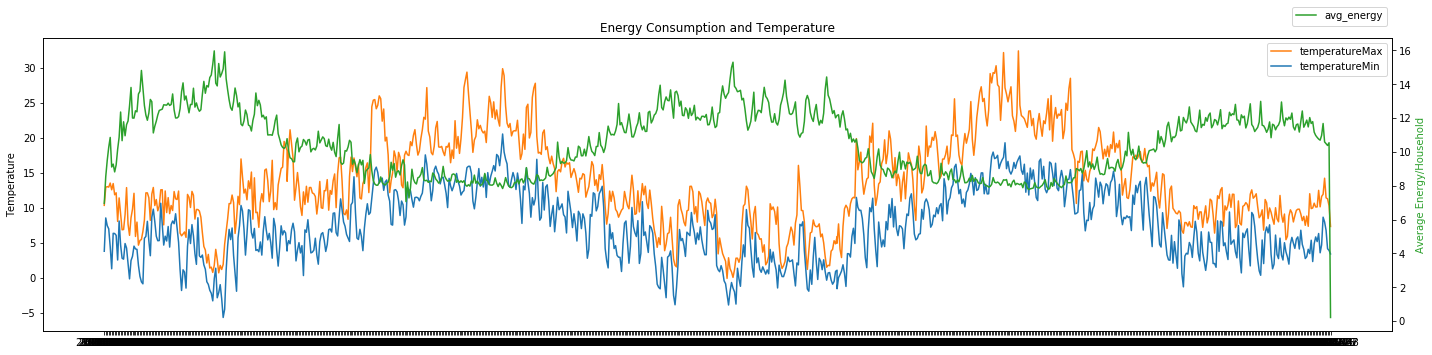

In [66]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy_holiday.day, weather_energy_holiday.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy_holiday.day, weather_energy_holiday.temperatureMin, color = 'tab:blue')
ax1.set_ylabel('Temperature')
ax1.legend(("temperatureMax","temperatureMin"))
ax2 = ax1.twinx()
ax2.plot(weather_energy_holiday.day,weather_energy_holiday.avg_energy,color = 'tab:green',label="avg_energy")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()


In [3]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='EnergyConsumptionAndTemperature&#47;TemperatureAndAvgEnergyConsumptionperHouseholdTrend' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

We can see that energy and temperature have an inverse relationship-we can see the peak in one appearing with troughs in the other. This confirms the business intuition that during low temperature, it is likely that the energy consumption through heaters etc. increases

# Humidity


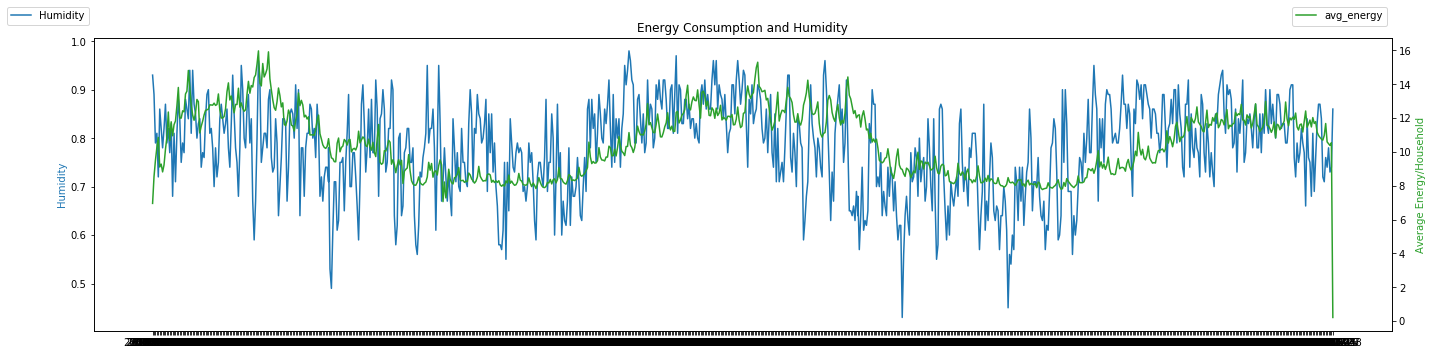

In [68]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy_holiday.day, weather_energy_holiday.humidity, color = 'tab:blue',label="Humidity")
ax1.set_ylabel('Humidity',color = 'tab:blue')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 0.0, 0.102))
ax2 = ax1.twinx()
ax2.plot(weather_energy_holiday.day,weather_energy_holiday.avg_energy,color = 'tab:green',label="avg_energy")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

In [4]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='HumidityAndAvgEnergyConsumptionperHousehold&#47;HumidityAndAvgEnergyConsumptionperHousehold' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

Humidity and the average consumption of energy seems to have the same trend.

# Cloud Cover

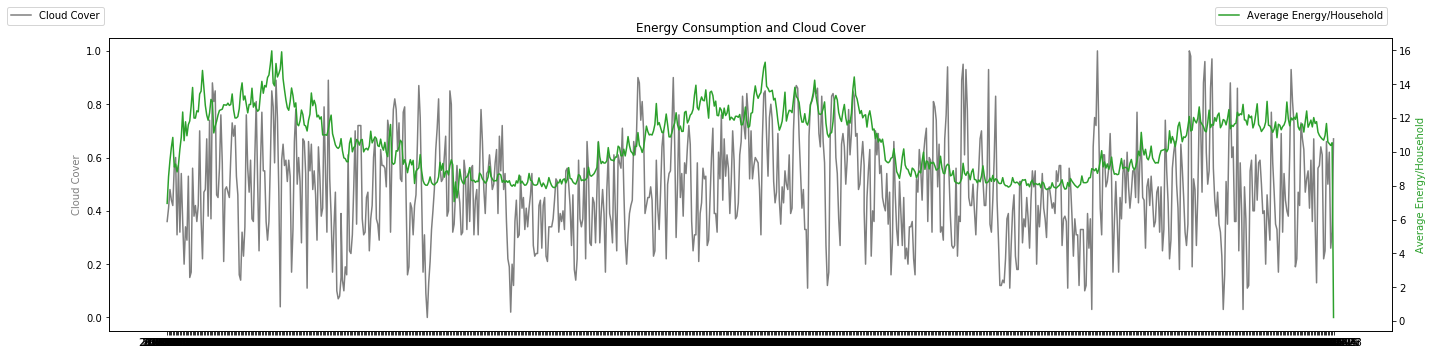

In [70]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy_holiday.day, weather_energy_holiday.cloudCover, color = 'tab:grey',label="Cloud Cover")
ax1.set_ylabel('Cloud Cover',color = 'tab:grey')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 0.0, 0.102))
ax2 = ax1.twinx()
ax2.plot(weather_energy_holiday.day,weather_energy_holiday.avg_energy,color = 'tab:green',label="Average Energy/Household")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

In [4]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='CloudCoverAndAvgEnergyConsumptionperHousehold&#47;CloudCoverAndAvgEnergyConsumptionperHousehold' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

The cloud cover value seems to be following the same pattern as the energy consumption.

# Visibility

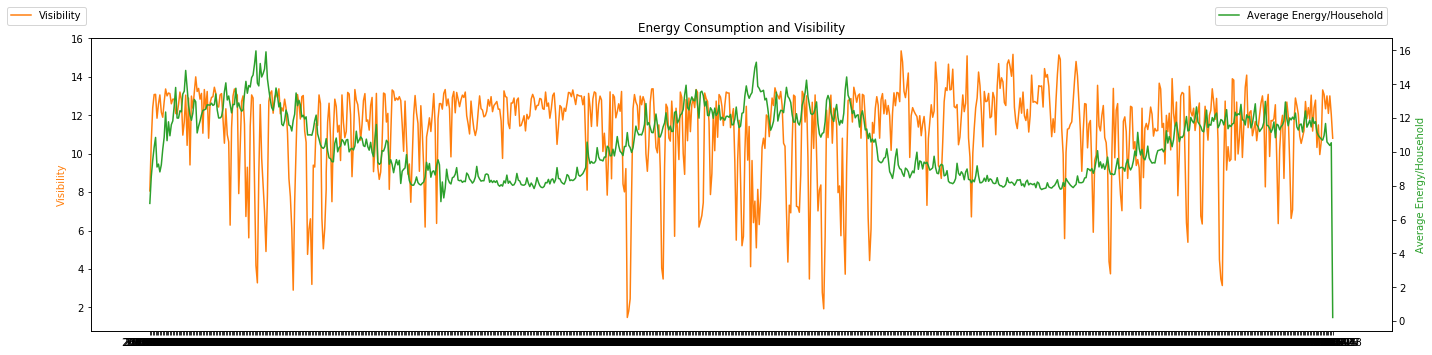

In [72]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy_holiday.day, weather_energy_holiday.visibility, color = 'tab:orange',label="Visibility")
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 0.0, 0.102))
ax2 = ax1.twinx()
ax2.plot(weather_energy_holiday.day,weather_energy_holiday.avg_energy,color = 'tab:green',label="Average Energy/Household")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

In [5]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='VisibilityAndAvgEnergyConsumptionperHousehold&#47;VisibilityAndAvgEnergyConsumptionperHousehold' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

The visibility factor does not seem to affect energy consumption at all- since visibility is most likely an outdoors factor, it is unlikely that it's increase or decrease affects energy consumption within a household.

# Wind Speed

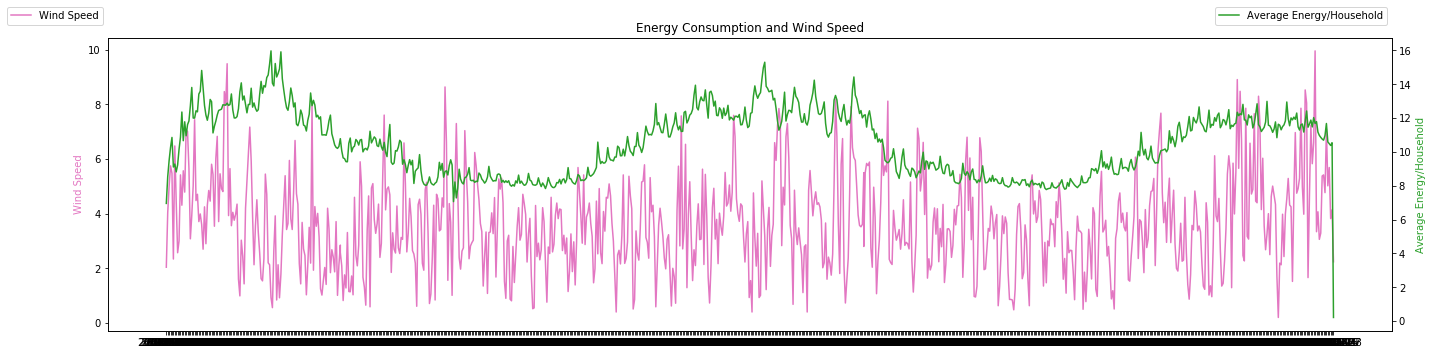

In [74]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy_holiday.day, weather_energy_holiday.windSpeed, color = 'tab:pink',label="Wind Speed")
ax1.set_ylabel('Wind Speed',color = 'tab:pink')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 0.0, 0.102))
ax2 = ax1.twinx()
ax2.plot(weather_energy_holiday.day,weather_energy_holiday.avg_energy,color = 'tab:green',label="Average Energy/Household")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

In [6]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='WindAndAvgEnergyConsumptionperHousehold&#47;WindSpeedAndAvgEnergyConsumptionperHousehold' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

Like visibility, wind speed seems to be an outdoors factor which does not affect in the energy consumption as such.

# UV Index

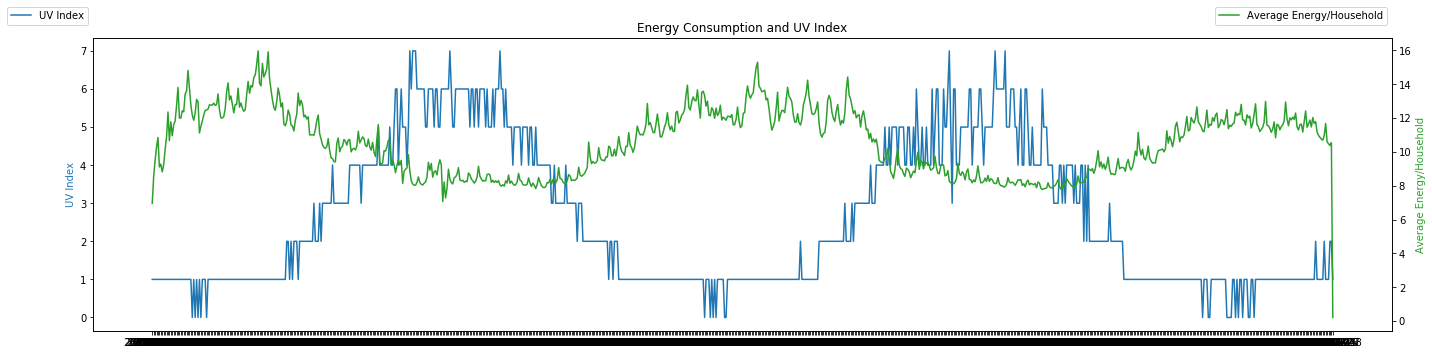

In [76]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy_holiday.day, weather_energy_holiday.uvIndex, color = 'tab:blue',label="UV Index")
ax1.set_ylabel('UV Index',color = 'tab:blue')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 0.0, 0.102))
ax2 = ax1.twinx()
ax2.plot(weather_energy_holiday.day,weather_energy_holiday.avg_energy,color = 'tab:green',label="Average Energy/Household")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

In [7]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='UVIndexAndAvgEnergyConsumptionperHousehold&#47;UVIndexAndAvgEnergyConsumptionperHousehold' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

The UV index has an inverse relationship with energy consumption

# Dew Point

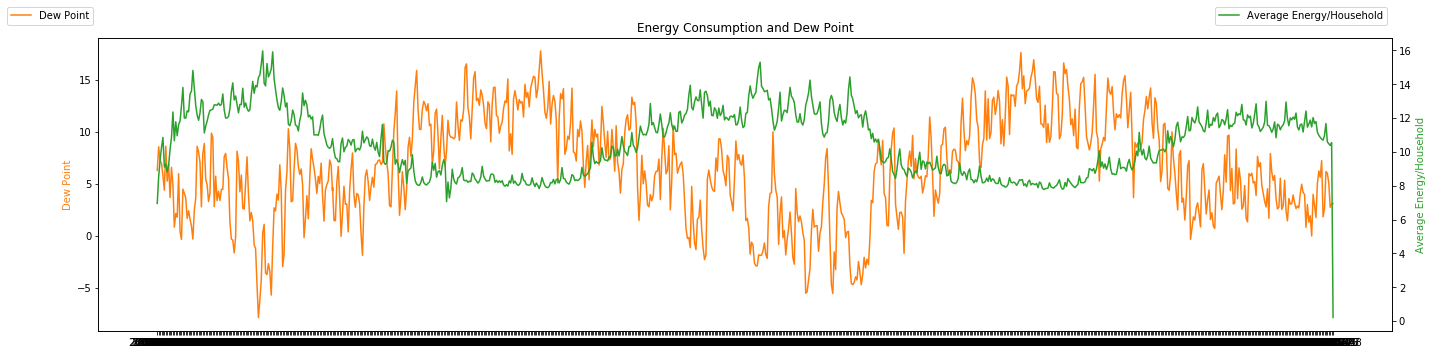

In [78]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy_holiday.day, weather_energy_holiday.dewPoint, color = 'tab:orange',label="Dew Point")
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 0.0, 0.102))
ax2 = ax1.twinx()
ax2.plot(weather_energy_holiday.day,weather_energy_holiday.avg_energy,color = 'tab:green',label="Average Energy/Household")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

In [8]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='DewPointAndAvgEnergyConsumptionperHousehold&#47;DewPointAndAvgEnergyConsumptionperHousehold' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

Dew Point- is a function of humidity and temperature therefore it displays similar relation to energy consumption.

# Holidays

In [9]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='HolidayAndAvgEnergyConsumptionperHousehold&#47;HolidayAndAvgEnergyConsumptionperHousehold' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

Avg Energy Consumption per Household is greater on Holidays compared with normal days

# Pressure

In [9]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='PressureAndAvgEnergyConsumptionperHousehold&#47;PressureAndAvgEnergyConsumptionperHousehold' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

No relationship between Pressure and Average Energy Consumption per Household

# MoonPhase

In [10]:
%%HTML
<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1600px; height: 735px;'><object class='tableauViz' width='1600' height='735' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;abhimirgesocial' /><param name='name' value='MoonPhaseAndAvgEnergyConsumptionperHousehold&#47;MoonPhaseAndAvgEnergyConsumptionperHousehold' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

No relationship between Moon Phase and Average Energy Consumption per Household